In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "HistoricalQuotes.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "tarunpaparaju/apple-aapl-historical-stock-data",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

C:\Users\Sujay\AppData\Local\Temp\ipykernel_3932\1238359749.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 142k/142k [00:00<00:00, 148kB/s]

First 5 records:          Date  Close/Last     Volume      Open      High       Low
0  02/28/2020     $273.36  106721200   $257.26   $278.41   $256.37
1  02/27/2020     $273.52   80151380    $281.1      $286   $272.96
2  02/26/2020     $292.65   49678430   $286.53   $297.88    $286.5
3  02/25/2020     $288.08   57668360   $300.95   $302.53   $286.13
4  02/24/2020     $298.18   55548830   $297.26   $304.18   $289.23


In [9]:
# Focus on 'Close' price
if 'df' in locals():
    # Strip column names
    df.columns = df.columns.str.strip()
    
    # Clean 'Close/Last' column: remove '$' and convert to float
    df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
    
    # Convert Date to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    data = df['Close/Last'].values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split into training (80%) and testing (20%)
    train_size = int(len(scaled_data) * 0.8)
    test_size = len(scaled_data) - train_size
    train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

    print(f"Training data size: {len(train_data)}")
    print(f"Testing data size: {len(test_data)}")

Training data size: 2014
Testing data size: 504


In [10]:
def create_sequences(dataset, seq_length=60):
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i+seq_length, 0])
        y.append(dataset[i+seq_length, 0])
    return np.array(X), np.array(y)

if 'train_data' in locals():
    seq_length = 60
    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)

    # Reshape input to be [samples, time steps, features] which is required for RNN
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

X_train shape: (1954, 60, 1)
y_train shape: (1954,)
X_test shape: (444, 60, 1)
y_test shape: (444,)


In [11]:
# Build the RNN model
if 'X_train' in locals():
    model = Sequential()
    # RNN layer with 50 units
    model.add(SimpleRNN(50, return_sequences=False, input_shape=(seq_length, 1)))
    # Dense layer with 1 unit
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.summary()

c:\Sujay\Christ\sem4\nlp\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
if 'model' in locals() and 'X_train' in locals():
    history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0063 - val_loss: 0.0120
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0063 - val_loss: 0.0120
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3618e-04 - val_loss: 0.0073
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3618e-04 - val_loss: 0.0073
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0171e-04 - val_loss: 0.0060
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0171e-04 - val_loss: 0.0060
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.6127e-05 - val_loss: 0.0055
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.6127e-05 - val_loss: 0.0055
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.0060e-05 - val_loss: 0.0050
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.0060e-05 - val_loss: 0.0050
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.2269e-05 - val_loss: 0.0045
Epoch 7/50
62/62 ━━━━━━━━━━━━

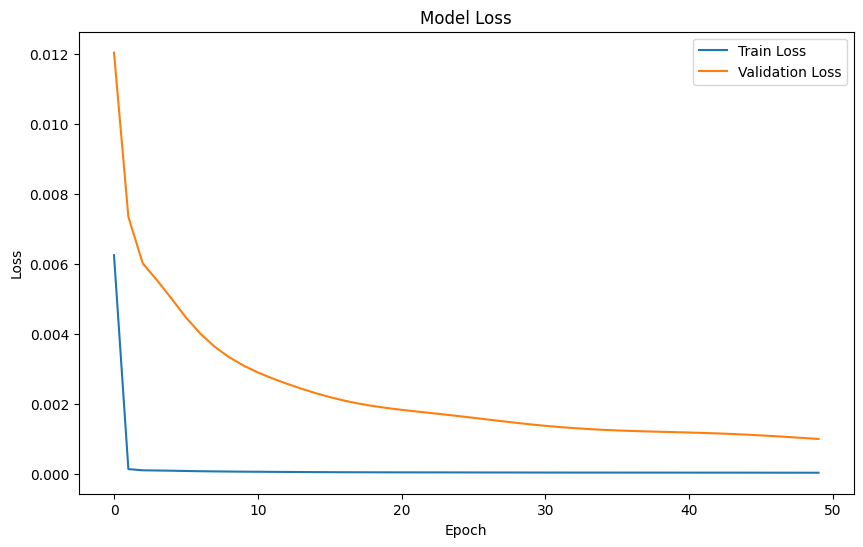

In [13]:
# Plot training & validation loss values
if 'history' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


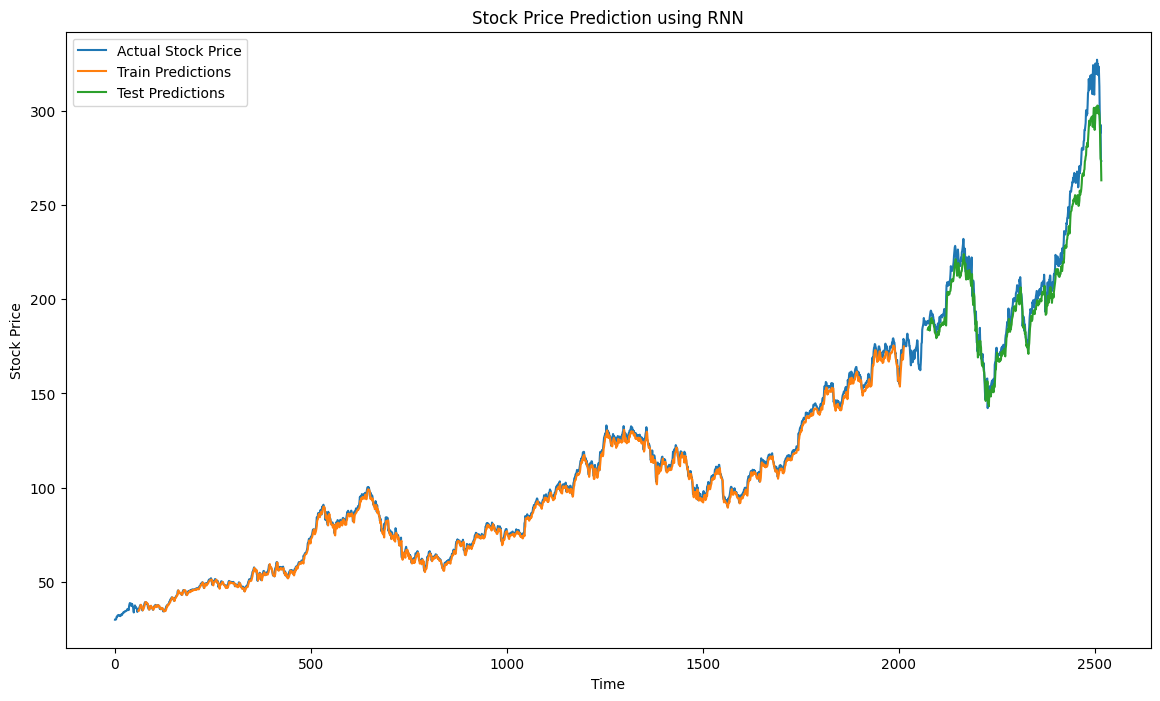

In [14]:
# Make predictions
if 'model' in locals() and 'X_train' in locals():
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Transform back to original form
    train_predict = scaler.inverse_transform(train_predict)
    y_train_inv = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform([y_test])

    # Plot the results
    plt.figure(figsize=(14, 8))
    
    # We need to align the predictions with the original dataframe indices
    # Train predictions
    train_predict_plot = np.empty_like(scaled_data)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[seq_length:len(train_predict)+seq_length, :] = train_predict
    
    # Test predictions
    test_predict_plot = np.empty_like(scaled_data)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict)+(seq_length*2):len(scaled_data), :] = test_predict
    
    plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Price')
    plt.plot(train_predict_plot, label='Train Predictions')
    plt.plot(test_predict_plot, label='Test Predictions')
    
    plt.title('Stock Price Prediction using RNN')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [15]:
# Evaluation
if 'y_test_inv' in locals() and 'test_predict' in locals():
    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test_inv.flatten(), test_predict.flatten())
    rmse = math.sqrt(mean_squared_error(y_test_inv.flatten(), test_predict.flatten()))

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Brief discussion
    print("\nDiscussion:")
    print(f"The model achieved an MAE of {mae:.2f} and an RMSE of {rmse:.2f}.")
    print("The plot shows how well the predicted prices follow the actual trends.")
    print("RNNs are good at capturing temporal dependencies, but SimpleRNN can suffer from vanishing gradient problems for very long sequences.")
    print("LSTMs or GRUs might provide better performance for longer term dependencies.")

Mean Absolute Error (MAE): 7.3890595128514756
Root Mean Squared Error (RMSE): 9.391974141761027

Discussion:
The model achieved an MAE of 7.39 and an RMSE of 9.39.
The plot shows how well the predicted prices follow the actual trends.
RNNs are good at capturing temporal dependencies, but SimpleRNN can suffer from vanishing gradient problems for very long sequences.
LSTMs or GRUs might provide better performance for longer term dependencies.
